<h1>Importación de librerias</h1>

In [1]:
import torch

# Verificar si CUDA (GPU) está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo en uso: {device}")

Dispositivo en uso: cuda


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from keras.preprocessing.image import load_img, img_to_array


# Configuración de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

# Hiperparámetros
batch_size = 128
epochs = 38  # Definimos los epochs
learning_rate = 0.0001

Usando: cuda


<h1>Mostrando las imágenes</h1>

In [15]:
picture_size = 48 #Se cambio de 128 a 48 debido a que el modelo puede resultar muy pesado
folder_path = "C:/Users/luiso/OneDrive/Escritorio/Tec2025/Inteligencia_Artificial/U4/albumentations_output/"

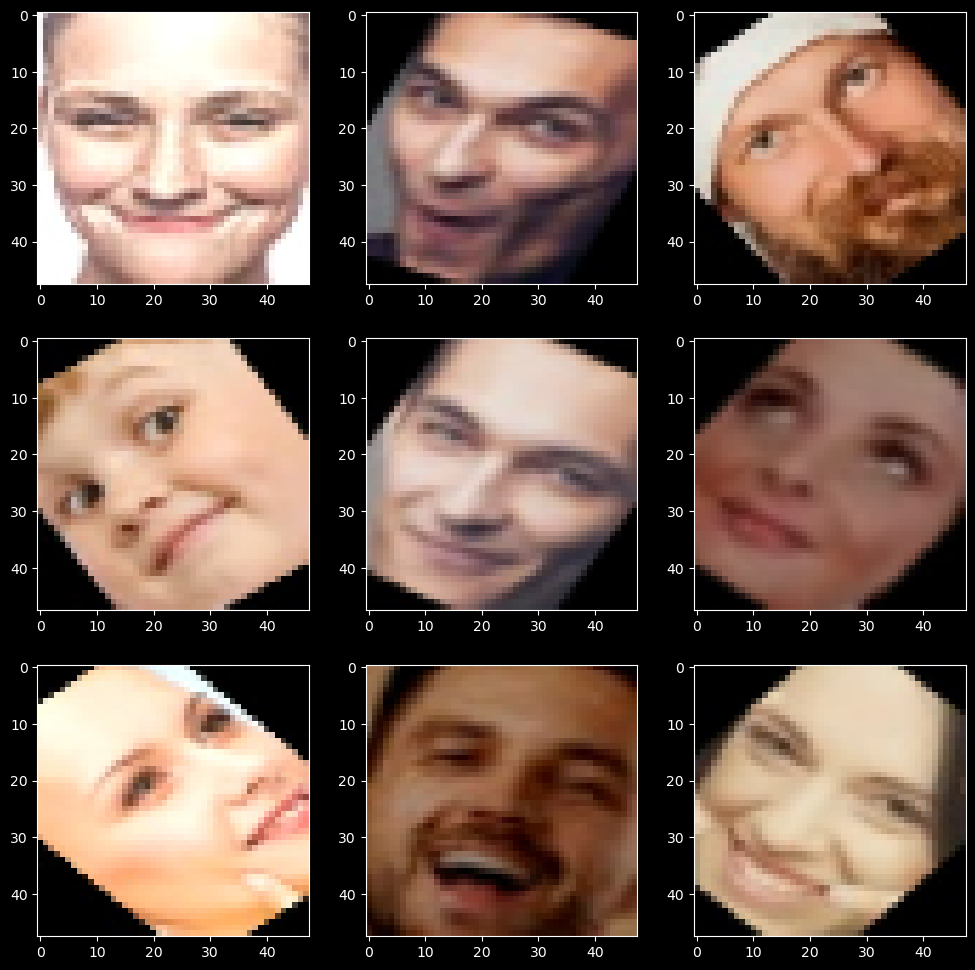

In [16]:
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize = (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path + "train/" + expression + "/" +
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)
plt.show()

In [17]:
# Transformaciones para las imágenes (con data augmentation solo en entrenamiento)
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((picture_size, picture_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((picture_size, picture_size)),
    # Normalizar: valores medios y desviaciones estándar para imágenes en escala de grises
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(
    folder_path + "train",
    transform=train_transform
)
test_dataset = datasets.ImageFolder(
    folder_path + "validation",
    transform=test_transform
)

# DataLoaders (optimizados para GPU)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, 
    pin_memory=True, num_workers=4
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    pin_memory=True, num_workers=4
)

<h1>Construccion del Modelo</h1>

In [18]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EmotionCNN, self).__init__()
        
        # Bloques convolucionales (como en tu modelo Keras)
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25),
        )
        
        # Capas fully connected
        self.classifier = nn.Sequential(
            nn.Linear(512 * 3 * 3, 256),  # Ajusta según el tamaño final de tus features
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.25),
            
            nn.Linear(512, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = EmotionCNN(num_classes=4).to(device)  # Mueve el modelo a GPU

In [19]:
# Optimizador y función de pérdida (equivalente a Adam y categorical_crossentropy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Callbacks en PyTorch
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. EarlyStopping
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Detener entrenamiento
        return False

early_stopping = EarlyStopping(patience=10)

# 2. ModelCheckpoint (guardar el mejor modelo)
best_val_accuracy = 0.0

# 3. ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=10, verbose=True)

c:\Users\luiso\anaconda3\envs\emocionesCNN\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
from tqdm import tqdm  # Importar la librería
import time

# Listas para métricas
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Barra de progreso para el entrenamiento
    train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)
    
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        # Actualizar la barra de progreso con métricas en tiempo real
        train_loader_tqdm.set_postfix({
            'Loss': running_loss / (total_train / batch_size),
            'Acc': 100 * correct_train / total_train
        })
    
    # Métricas de entrenamiento
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validación (con barra de progreso)
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    val_loader_tqdm = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)
    
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_loader_tqdm.set_postfix({
                'Val Loss': val_loss / (total_val / batch_size),
                'Val Acc': 100 * correct_val / total_val
            })
    
    # Métricas de validación
    val_loss /= len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Callbacks
    scheduler.step(val_loss)
    
    # ModelCheckpoint
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "best_model.pth")
        print(f"\nMejor modelo guardado con val_accuracy: {val_accuracy:.2f}%")
    
    # EarlyStopping
    if early_stopping(val_loss):
        print("\nEarlyStopping activado!")
        break
    
    # Resumen de la época (en color para mejor legibilidad)
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    print("─" * 50)


Mejor modelo guardado con val_accuracy: 23.60%

Epoch 1/38
Train Loss: 1.3981 | Train Acc: 30.40%
Val Loss: 1.4739 | Val Acc: 23.60%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 26.22%

Epoch 2/38
Train Loss: 1.3241 | Train Acc: 37.76%
Val Loss: 1.4376 | Val Acc: 26.22%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 28.83%

Epoch 3/38
Train Loss: 1.2896 | Train Acc: 39.83%
Val Loss: 1.4486 | Val Acc: 28.83%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 32.79%

Epoch 4/38
Train Loss: 1.2548 | Train Acc: 41.83%
Val Loss: 1.4004 | Val Acc: 32.79%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 32.88%

Epoch 5/38
Train Loss: 1.2177 | Train Acc: 45.36%
Val Loss: 1.3934 | Val Acc: 32.88%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 36.67%

Epoch 6/38
Train Loss: 1.1819 | Train Acc: 46.52%
Val Loss: 1.3877 | Val Acc: 36.67%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 38.38%

Epoch 7/38
Train Loss: 1.1607 | Train Acc: 48.26%
Val Loss: 1.3467 | Val Acc: 38.38%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 39.46%

Epoch 8/38
Train Loss: 1.1430 | Train Acc: 49.93%
Val Loss: 1.2654 | Val Acc: 39.46%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 41.35%

Epoch 9/38
Train Loss: 1.1077 | Train Acc: 51.55%
Val Loss: 1.2515 | Val Acc: 41.35%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 42.97%

Epoch 10/38
Train Loss: 1.0839 | Train Acc: 52.57%
Val Loss: 1.2812 | Val Acc: 42.97%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 47.39%

Epoch 11/38
Train Loss: 1.0652 | Train Acc: 53.12%
Val Loss: 1.1985 | Val Acc: 47.39%
──────────────────────────────────────────────────



Epoch 12/38
Train Loss: 1.0399 | Train Acc: 54.76%
Val Loss: 1.2093 | Val Acc: 45.41%
──────────────────────────────────────────────────



Epoch 13/38
Train Loss: 1.0339 | Train Acc: 56.07%
Val Loss: 1.2307 | Val Acc: 45.32%
──────────────────────────────────────────────────



Epoch 14/38
Train Loss: 1.0050 | Train Acc: 56.24%
Val Loss: 1.3558 | Val Acc: 41.89%
──────────────────────────────────────────────────



Epoch 15/38
Train Loss: 0.9931 | Train Acc: 58.19%
Val Loss: 1.2169 | Val Acc: 47.03%
──────────────────────────────────────────────────



Epoch 16/38
Train Loss: 0.9759 | Train Acc: 59.33%
Val Loss: 1.2710 | Val Acc: 44.32%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 51.53%

Epoch 17/38
Train Loss: 0.9641 | Train Acc: 58.83%
Val Loss: 1.1446 | Val Acc: 51.53%
──────────────────────────────────────────────────



Epoch 18/38
Train Loss: 0.9449 | Train Acc: 60.48%
Val Loss: 1.1380 | Val Acc: 50.99%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 56.13%

Epoch 19/38
Train Loss: 0.9323 | Train Acc: 60.79%
Val Loss: 1.0576 | Val Acc: 56.13%
──────────────────────────────────────────────────



Epoch 20/38
Train Loss: 0.9163 | Train Acc: 62.36%
Val Loss: 1.0815 | Val Acc: 54.32%
──────────────────────────────────────────────────



Epoch 21/38
Train Loss: 0.9009 | Train Acc: 63.00%
Val Loss: 1.1075 | Val Acc: 51.17%
──────────────────────────────────────────────────



Epoch 22/38
Train Loss: 0.9068 | Train Acc: 61.71%
Val Loss: 1.1408 | Val Acc: 51.98%
──────────────────────────────────────────────────



Epoch 23/38
Train Loss: 0.8801 | Train Acc: 64.19%
Val Loss: 1.1286 | Val Acc: 52.07%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 57.39%

Epoch 24/38
Train Loss: 0.8701 | Train Acc: 63.64%
Val Loss: 1.0737 | Val Acc: 57.39%
──────────────────────────────────────────────────



Epoch 25/38
Train Loss: 0.8514 | Train Acc: 65.52%
Val Loss: 1.0885 | Val Acc: 53.51%
──────────────────────────────────────────────────



Epoch 26/38
Train Loss: 0.8469 | Train Acc: 64.57%
Val Loss: 1.0770 | Val Acc: 54.41%
──────────────────────────────────────────────────



Epoch 27/38
Train Loss: 0.8373 | Train Acc: 65.45%
Val Loss: 1.0652 | Val Acc: 55.23%
──────────────────────────────────────────────────



Epoch 28/38
Train Loss: 0.8132 | Train Acc: 67.40%
Val Loss: 1.0928 | Val Acc: 55.32%
──────────────────────────────────────────────────



Epoch 29/38
Train Loss: 0.8008 | Train Acc: 67.00%
Val Loss: 1.0567 | Val Acc: 57.03%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 58.29%

Epoch 30/38
Train Loss: 0.8056 | Train Acc: 66.98%
Val Loss: 1.0332 | Val Acc: 58.29%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 58.92%

Epoch 31/38
Train Loss: 0.7874 | Train Acc: 67.69%
Val Loss: 1.0308 | Val Acc: 58.92%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 59.01%

Epoch 32/38
Train Loss: 0.7805 | Train Acc: 68.48%
Val Loss: 1.0264 | Val Acc: 59.01%
──────────────────────────────────────────────────



Epoch 33/38
Train Loss: 0.7737 | Train Acc: 68.50%
Val Loss: 1.0454 | Val Acc: 59.01%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 60.45%

Epoch 34/38
Train Loss: 0.7612 | Train Acc: 68.71%
Val Loss: 1.0143 | Val Acc: 60.45%
──────────────────────────────────────────────────



Mejor modelo guardado con val_accuracy: 61.98%

Epoch 35/38
Train Loss: 0.7508 | Train Acc: 69.07%
Val Loss: 0.9765 | Val Acc: 61.98%
──────────────────────────────────────────────────



Epoch 36/38
Train Loss: 0.7518 | Train Acc: 69.93%
Val Loss: 0.9974 | Val Acc: 60.63%
──────────────────────────────────────────────────



Epoch 37/38
Train Loss: 0.7323 | Train Acc: 70.12%
Val Loss: 1.0109 | Val Acc: 60.45%
──────────────────────────────────────────────────



Epoch 38/38
Train Loss: 0.7265 | Train Acc: 70.86%
Val Loss: 0.9902 | Val Acc: 61.53%
──────────────────────────────────────────────────


<h1>Trazando la presición y perdidas</h1>

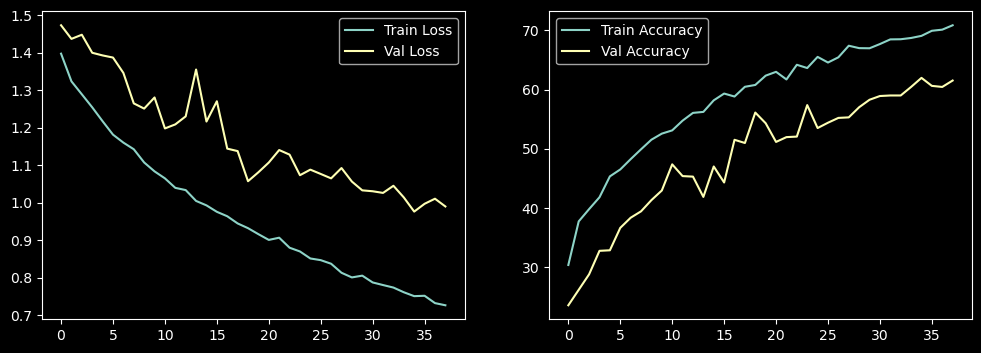

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.show()

<h1>Guardar el modelo</h1>

In [22]:
torch.save(model.state_dict(), 'modelo_CNN_state_dict.pth')

<h1>Matriz de confusión</h1>

In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class ConfusionMatrixEvaluator:
    def __init__(self, model, dataloader, class_names, device):
        self.model = model
        self.dataloader = dataloader
        self.class_names = class_names
        self.device = device

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        cr = classification_report(all_labels, all_preds, target_names=self.class_names, digits=3)

        # Mostrar la matriz de confusión
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        print("Classification Report:")
        print(cr)


C:\Users\luiso\AppData\Local\Temp\ipykernel_23144\771655050.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("modelo_CNN_state_dict.pth",

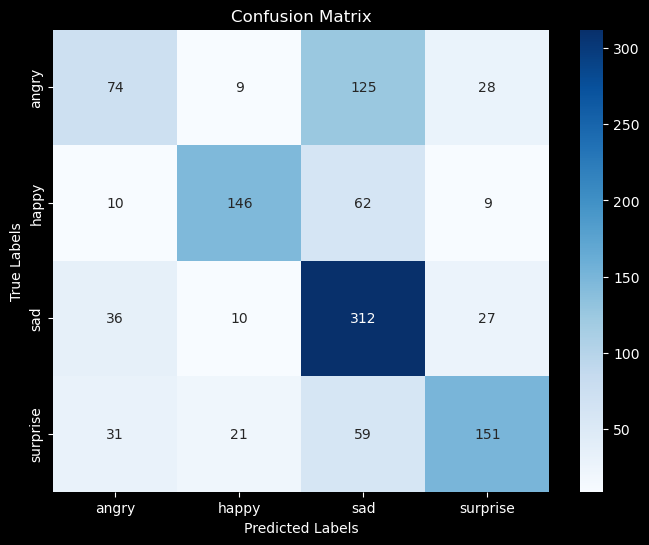

Classification Report:
              precision    recall  f1-score   support

       angry      0.490     0.314     0.382       236
       happy      0.785     0.643     0.707       227
         sad      0.559     0.810     0.662       385
    surprise      0.702     0.576     0.633       262

    accuracy                          0.615      1110
   macro avg      0.634     0.586     0.596      1110
weighted avg      0.624     0.615     0.605      1110



In [25]:
# Cargar el modelo entrenado
model.load_state_dict(torch.load("modelo_CNN_state_dict.pth", map_location=device))
model.to(device)

# Obtener nombres de las clases
class_names = train_dataset.classes  # ['angry', 'happy', 'sad', 'surprise']

# Crear evaluador y mostrar matriz de confusión
evaluator = ConfusionMatrixEvaluator(model, test_loader, class_names, device)
evaluator.evaluate()
